In [309]:
import numpy as np
import pandas as pd
import os
import IPython.display
import urllib.request
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [799]:
DATA_PATH = 'data'
MIN_LAT = 40.49612
MAX_LAT = 40.91553
MIN_LON = -74.25559
MAX_LON = -73.70001
D_LAT = (MAX_LAT - MIN_LAT)/50.
D_LON = (MAX_LON - MIN_LON)/50.
CHUNK_SIZE = 10**6
MIN_YEAR = 2009

In [850]:
# Список загруженных файлов
raw_data_paths = [(2016, 5, (2016-MIN_YEAR)*12+5-1, os.path.join(DATA_PATH, 'yellow_tripdata_2016-05.csv'))]
# Список ссылок со всем объемом данных
raw_data_urls = [(y, m, (y-MIN_YEAR)*12+m-1, "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_{}-{:0>2}.csv".format(y, m))
                 for y in range(2017, 2008, -1) for m in range(12, 0, -1)]

# Список идентификаторов зон (начинается с 1)
regions_index = np.arange(2500)+1

# Список временных меток по часам с начала месяца
def build_hours_index(y, m):
    return pd.DatetimeIndex(start=pd.Timestamp(year=y, month=m, day=1), freq='h', periods=744)

# Загрузка первой строки (заголовков таблицы) файла по ссылке url
def download_columns(url):
    with urllib.request.urlopen(url) as stream: return(stream.readline())

# Извлечение временной метки отправления из строки файла данных
def get_pickup_datetime(row):
    return pd.Timestamp(row[1])

# Извлечение временной метки прибытия из строки файла данных
def get_dropoff_datetime(row):
    return pd.Timestamp(row[2])

# Извлечение количества пассажиров из строки файла данных
def get_passenger_count(row):
    return int(row[3])

# Извлечение дальности поездки из строки файла данных
def get_trip_distance(row):
    return float(row[4])

# Извлечение долготы отправления из строки файла данных
def get_pickup_lon(row, file_i):
    if file_i>=90: return np.nan
    else: return float(row[5])
    
# Извлечение долготы отправления из строки файла данных
def get_pickup_lat(row, file_i):
    if file_i>=90: return np.nan
    else: return float(row[6])

# Вычисление индекса зоны по долготе и широте
# ! Индекс региона на 1 меньше, чем в файле regions.csv
def calc_region_id(lon, lat):
    return int(50*np.floor((lon-MIN_LON)/D_LON) + np.floor((lat-MIN_LAT)/D_LAT))

# Извлечение зоны отправления из строки файла данных
def calc_pickup_region(row, file_i):
    if file_i>=90: return int(row[7])
    else: return calc_region_id(float(row[5]), float(row[6]))

# Вычисление индексов агрегированного массива для обработки строки файла данных
def calc_indices(row, file_i):
    pu_datetime = get_pickup_datetime(row)
    # Порядковый номер часа с начала месяца (начинается с 0)
    hour_id = (pu_datetime.day-1)*24 + pu_datetime.hour
    region_id = calc_pickup_region(row, file_i)
    return (hour_id, region_id)

# Проверка строки файла данных на ошибки и аномалии
def check_data_row(row, file_i):
    if file_i>=90: # с июля 2016
        return ((get_dropoff_datetime(row) > get_pickup_datetime(row)) 
                and (get_trip_distance(row) > 0)
                and (get_passenger_count(row) > 0) 
               )
    else: # до июля 2016
        return ((get_dropoff_datetime(row) > get_pickup_datetime(row)) # с ненулевой длительностью
                and (get_trip_distance(row) > 0) # с ненулевым расстоянием
                and (get_passenger_count(row) > 0) # с ненулевым количеством пассажиров
                and (get_pickup_lon(row, file_i) > MIN_LON) # попадают в прямоугольник Нью-Йорка
                and (get_pickup_lon(row, file_i) < MAX_LON)
                and (get_pickup_lat(row, file_i) > MIN_LAT)
                and (get_pickup_lat(row, file_i) < MAX_LAT)
               )

# Агрегирование файла (потока) данных
def process_stream(stream, file_i):
    # По строкам - порядковые номера часов с начала месяца (всего 31*24)
    # По столбцам - идентификаторы зон
    aggregated_data = np.zeros((744, 2500), dtype=np.uint16)
    # Читаем файл кусками по SHUNK_SIZE строк, не загружая в память целиком
    reader = pd.read_csv(stream, chunksize=CHUNK_SIZE)
    for (chunk_i, chunk) in enumerate(reader):
        filtered_n = 0
        for row in chunk.itertuples(index=False):
            if check_data_row(row, file_i):
                indices = calc_indices(row, file_i)
                aggregated_data[indices] += 1
            else: filtered_n += 1
        # Выводим сообщение о завершении обработки куска файла и количестве отфильтрованных строк
        print("done: chunk {}, filtered: {}/{}".format(chunk_i, filtered_n, CHUNK_SIZE))
    # Сохраняем агрегированный массив в файл
    with open("dump{}.pkl".format(file_i), 'wb') as dump_file: pickle.dump(aggregated_data, dump_file, protocol=2)

# Агрегирование списка файлов
def process_files(paths):
    for (y, m, file_i, path) in paths:
        print("START: {} - {}".format(file_i, path))
        with open(path, 'r') as stream: process_stream(stream, file_i)
        print("DONE: {} - {}".format(file_i, path))

# Агрегирование списка url
def process_urls(urls):
    for (y, m, file_i, url) in urls:
        print("START: {} - {}".format(file_i, url))
        with urllib.request.urlopen(url) as stream: process_stream(stream, file_i)
        print("DONE: {} - {}".format(file_i, url))

In [789]:
# Анализ заголовков таблиц по всему объему данных
with open("dump_columns.pkl", 'rb') as dump_file: columns = pickle.load(dump_file)
df = pd.DataFrame(row[1].decode('utf-8').split(',') for row in columns)
df['ind'] = range(107, -1, -1)
df['url'] = [row[0] for row in columns]
with pd.option_context('display.max_rows', 200):
    IPython.display.display(df.iloc[:,[5,-2,-1]])

# Выяснилось, что с июля 2016 г. формат записи меняется (вместо широты и долготы указывается идентификатор зоны)
# Кроме того, заголовки столбцов отличаются в разные месяцы (нужно извлекать данные не по заголовку столбца, а по порядковому номеру)

,5,ind,url
0,RatecodeID,107,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-12.csv
1,RatecodeID,106,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-11.csv
2,RatecodeID,105,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-10.csv
3,RatecodeID,104,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-09.csv
4,RatecodeID,103,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-08.csv
5,RatecodeID,102,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-07.csv
6,RatecodeID,101,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-06.csv
7,RatecodeID,100,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-05.csv
8,RatecodeID,99,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-04.csv
9,RatecodeID,98,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-03.csv


In [802]:
# Обработка данных за май 2016 г.
%%time
process_files(raw_data_paths)

START: 88 - data\yellow_tripdata_2016-05.csv
done: chunk 0, filtered: 17614/1000000
done: chunk 1, filtered: 17112/1000000
done: chunk 2, filtered: 16919/1000000
done: chunk 3, filtered: 18996/1000000
done: chunk 4, filtered: 18186/1000000
done: chunk 5, filtered: 17725/1000000
done: chunk 6, filtered: 19269/1000000
done: chunk 7, filtered: 18583/1000000
done: chunk 8, filtered: 16541/1000000
done: chunk 9, filtered: 17235/1000000
done: chunk 10, filtered: 17377/1000000
done: chunk 11, filtered: 14775/1000000
DONE: 88 - data\yellow_tripdata_2016-05.csv
Wall time: 9min 53s


In [798]:
# Заготовка для обработки всего объема данных
%%time
process_urls(raw_data_urls)

START: 107 - https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-12.csv
done: chunk 0, filtered: 5/10
DONE: 107 - https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-12.csv
START: 106 - https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-11.csv
done: chunk 0, filtered: 4/10
DONE: 106 - https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-11.csv
START: 105 - https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-10.csv
done: chunk 0, filtered: 0/10
DONE: 105 - https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-10.csv
START: 104 - https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-09.csv
done: chunk 0, filtered: 0/10
DONE: 104 - https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-09.csv
START: 103 - https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-08.csv
done: chunk 0, filtered: 1/10
DONE: 103 - https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-08.csv
START: 102 - ht

KeyboardInterrupt: 

In [733]:
with open("dump89.pkl", 'rb') as dump_file: aggregated_data = pickle.load(dump_file)

In [863]:
# Выводим часть агрегированной таблицы
# Столбцы соответствуют зонам, строки - часам с начала месяца
df = pd.DataFrame(aggregated_data, index=build_hours_index(2016, 5), columns=regions_index)
with pd.option_context('display.max_columns', 10, 'display.max_rows', 5):
    IPython.display.display(df)

,1,2,3,4,5,...,2496,2497,2498,2499,2500
2016-05-01 00:00:00,0,0,0,0,0,...,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31 22:00:00,0,0,0,0,0,...,0,0,0,0,0
2016-05-31 23:00:00,0,0,0,0,0,...,0,0,0,0,0


In [805]:
# Определяем номер ячейки, содержащей Empire State Building
calc_region_id(-73.985428, 40.748817)

1230

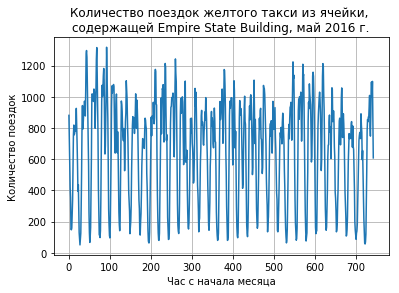

In [820]:
plt.xlabel('Час с начала месяца')
plt.ylabel('Количество поездок')
plt.title('Количество поездок желтого такси из ячейки, \nсодержащей Empire State Building, май 2016 г.')
plt.grid(True)
plt.plot(aggregated_data[:,1230])

In [892]:
# Количество пар час-ячейка, для которых не было ни одной поездки в мае 2016
empty_cell_n = np.sum(aggregated_data==0)
total_cells = np.prod(aggregated_data.shape)
empty_cell_n, total_cells, '{:.2f}'.format(empty_cell_n/total_cells)

(1718238, 1860000, '0.92')

In [883]:
np.where(np.array([[1,2,0],[4,1,0]])==0)

(array([0, 1], dtype=int64), array([2, 2], dtype=int64))

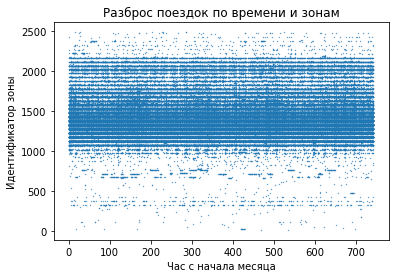

In [893]:
(x, y) = np.where(aggregated_data!=0)
plt.xlabel('Час с начала месяца')
plt.ylabel('Идентификатор зоны')
plt.title('Разброс поездок по времени и зонам')
plt.scatter(x, y, s=0.1)